In [1]:
# general
import xarray as xr
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import matplotlib.ticker as plticker
import time
import cmocean
from tqdm.auto import tqdm

# import sys
# sys.path.append("..")

# custom
from block_update import *
from bouguer import *
from rfgen import *
from prisms import *
from diagnostics import *
from utilities import *

In [2]:
ds = xr.load_dataset(Path('thwaites/processed_data/xr_2000.nc'))
grav = pd.read_csv(Path('thwaites/processed_data/grav_leveled_2000.csv'))

grav.head()

,x,y,faa,height,msk,inv_msk,inv_pad
0,-1597500.0,-703500.0,13.440270,1200,False,0.0,True
1,-1595500.0,-703500.0,17.447241,1200,False,0.0,True
2,-1593500.0,-703500.0,20.774091,1200,False,0.0,True
3,-1591500.0,-703500.0,22.612817,1200,False,0.0,True
4,-1589500.0,-703500.0,23.245403,1200,False,0.0,False


In [3]:
terrain_g = bm_terrain_effect(ds, grav, 2670)

In [4]:
faa_grid, terrain_grid = xy_into_grid(ds, (grav.x.values, grav.y.values), (grav.faa, terrain_g))
boug_grid = faa_grid - terrain_grid

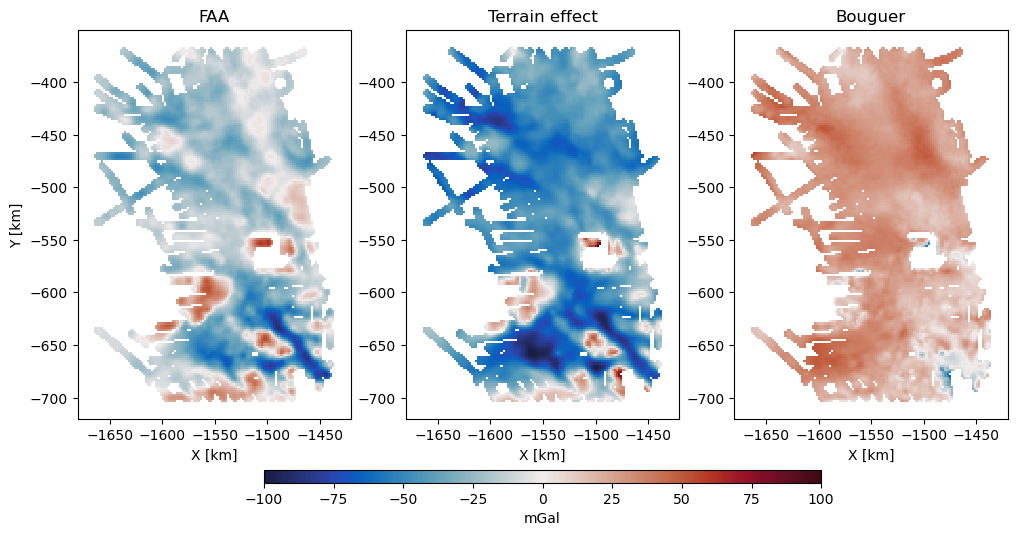

In [5]:
fig = plt.figure(figsize=(12,6))
gs = GridSpec(2, 3, height_ratios=[1, 0.03])
axs = []
for i in range(3):
    axs.append(fig.add_subplot(gs[0,i]))

#fig, axs = plt.subplots(1, 3, figsize=(12,8), sharey=True)
ax = axs[0]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, faa_grid, vmin=-100, vmax=100, cmap='cmo.balance')
ax.axis('scaled')
ax.set_title('FAA')
ax.set_ylabel('Y [km]')
ax.set_xlabel('X [km]')

ax = axs[1]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, terrain_grid, vmin=-100, vmax=100, cmap='cmo.balance')
ax.axis('scaled')
ax.set_title('Terrain effect')
ax.set_xlabel('X [km]')

ax = axs[2]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, boug_grid, vmin=-100, vmax=100, cmap='cmo.balance')
ax.axis('scaled')
ax.set_title('Bouguer')
ax.set_xlabel('X [km]')

gs2 = GridSpecFromSubplotSpec(1, 100, gs[1,:])
cax = fig.add_subplot(gs2[20:80])
plt.colorbar(im, cax=cax, orientation='horizontal', label='mGal')
plt.show()

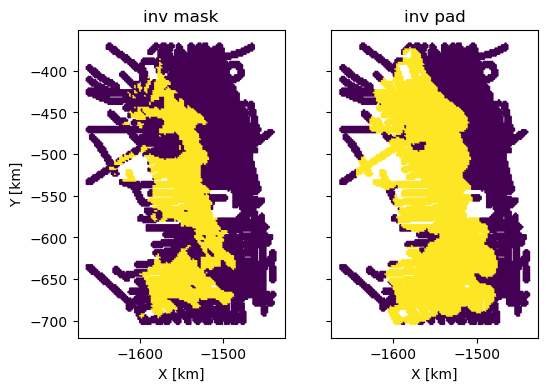

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(6,4), sharey=True)
ax = axs[0]
ax.scatter(grav.x/1000, grav.y/1000, c=grav.inv_msk, s=1)
ax.axis('scaled')
ax.set_title('inv mask')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax = axs[1]
ax.scatter(grav.x/1000, grav.y/1000, c=grav.inv_pad, s=1)
ax.axis('scaled')
ax.set_title('inv pad')
ax.set_xlabel('X [km]')
plt.show()

In [7]:
density = 2670
maxlag=100e3
n_lags=70
covmodel='spherical'
azimuth=0
minor_range_scale=1
k=64
rad=100e3

target = boug_interpolation_sgs(ds, grav, density, maxlag, n_lags, covmodel, azimuth, minor_range_scale, k, rad, quiet=False)

100%|██████████| 12404/12404 [00:43<00:00, 286.23it/s]


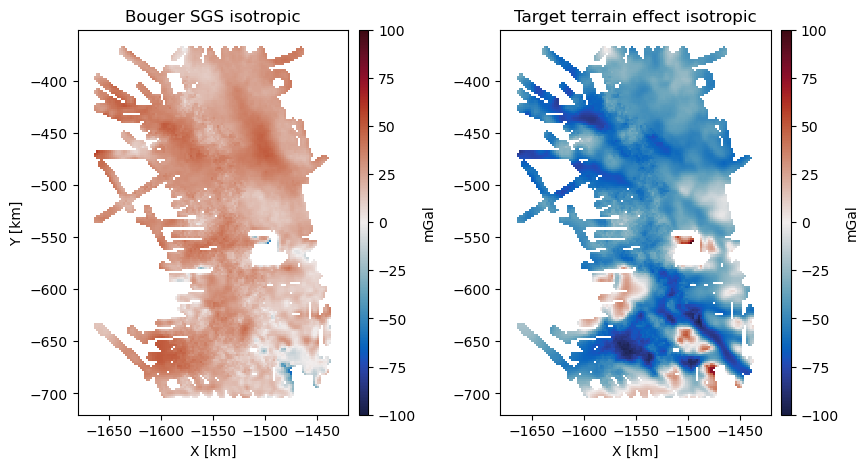

In [8]:
target_grid, sgs_boug_grid = xy_into_grid(ds, (grav.x.values, grav.y.values), (target, grav.faa-target))

fig, axs = plt.subplots(1, 2, figsize=(10,5))
ax = axs[0]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, sgs_boug_grid, vmin=-100, vmax=100, cmap='cmo.balance')
ax.axis('scaled')
ax.set_ylabel('Y [km]')
ax.set_xlabel('X [km]')
ax.set_title('Bouger SGS isotropic')
plt.colorbar(im, pad=0.03, aspect=40, label='mGal')

ax = axs[1]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, target_grid, vmin=-100, vmax=100, cmap='cmo.balance')
ax.axis('scaled')
ax.set_xlabel('X [km]')
ax.set_title('Target terrain effect isotropic')
plt.colorbar(im, pad=0.03, aspect=40, label='mGal')
plt.show()

# Anisotropic SGS simulation

I set the azimuth to minus 45 degrees and the minor range will be half of the major (normal) range.

In [9]:
density = 2670
maxlag=100e3
n_lags=70
covmodel='spherical'
azimuth=-45
minor_range_scale=0.5
k=64
rad=100e3

target_ani = boug_interpolation_sgs(ds, grav, density, maxlag, n_lags, covmodel, azimuth, minor_range_scale, k, rad, quiet=False)

100%|██████████| 12404/12404 [00:48<00:00, 257.41it/s]


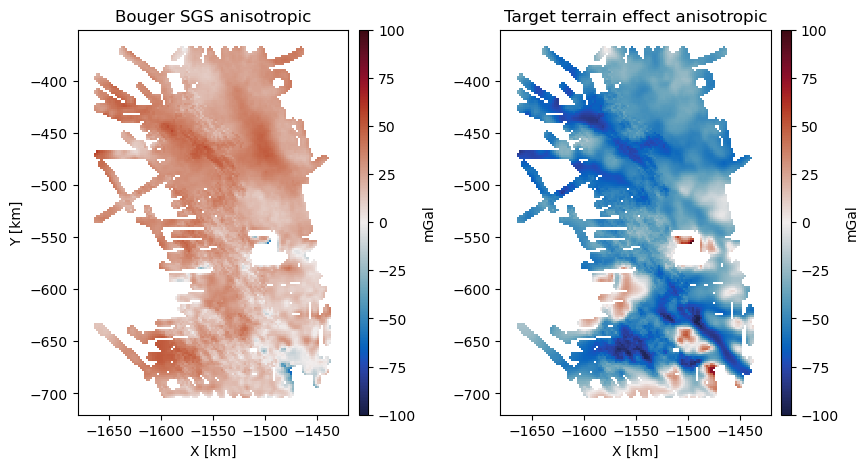

In [10]:
target_ani_grid, sgs_ani_boug_grid = xy_into_grid(ds, (grav.x.values, grav.y.values), (target_ani, grav.faa-target_ani))

fig, axs = plt.subplots(1, 2, figsize=(10,5))
ax = axs[0]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, sgs_ani_boug_grid, vmin=-100, vmax=100, cmap='cmo.balance')
ax.axis('scaled')
ax.set_ylabel('Y [km]')
ax.set_xlabel('X [km]')
ax.set_title('Bouger SGS anisotropic')
plt.colorbar(im, pad=0.03, aspect=40, label='mGal')

ax = axs[1]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, target_ani_grid, vmin=-100, vmax=100, cmap='cmo.balance')
ax.axis('scaled')
ax.set_xlabel('X [km]')
ax.set_title('Target terrain effect anisotropic')
plt.colorbar(im, pad=0.03, aspect=40, label='mGal')
plt.show()